In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score
from IPython import display

In [4]:
data = pd.read_csv('../../data/data_p1_jap_features.csv')
data.head()

,Unnamed: 0,W_rating,B_rating,mean_deltawinrate,mean_deltaScore50p,mean_deltascoreLead,dispersy_scoreLead,beautiful_percent,beautifulS_percent,mean_utility,...,mean_utility 20,mean_deltawinrate yose,beautiful_percent yose,beautifulS_percent yose,mean_deltascoreLead yose,mean_deltaSelfPlay yose,dispersy_scoreLead yose,mean_utility yose,mean_dist,dispersy_dist
0,0,3k,3k,-0.040488,-2.377734,-3.464560,23.954890,0.406667,0.160000,-0.088362,...,-0.000262,0.000260,0.226667,0.073333,-2.573400,-2.146336,10.538134,-0.004645,5.213333,20.514489
1,1,3k,3k,-0.043191,-0.491949,-0.753123,1.472670,0.375000,0.187500,-0.087056,...,-0.087056,-0.043191,0.375000,0.187500,-0.753123,-1.022411,1.472670,-0.087056,4.625000,19.234375
2,2,3k,3k,-0.089254,-2.030399,-2.458237,7.392600,0.272727,0.090909,-0.188092,...,-0.188092,-0.089254,0.272727,0.090909,-2.458237,-2.900573,7.392600,-0.188092,7.272727,68.925620
3,3,3k,3k,-0.019591,-0.824960,-3.583750,203.173883,0.536765,0.433824,-0.047196,...,0.030994,-0.066028,0.169118,0.088235,-9.081688,-7.362831,575.227179,-0.149602,5.845588,45.512922
4,4,3k,3k,-0.065001,-1.265764,-2.280660,15.159420,0.162791,0.162791,-0.137663,...,-0.175444,-0.087452,0.046512,0.046512,-5.938662,-5.755159,47.043784,-0.200001,5.558140,29.176852


In [11]:
data.columns

Index(['Unnamed: 0', 'W_rating', 'B_rating', 'mean_deltawinrate',
       'mean_deltaScore50p', 'mean_deltascoreLead', 'dispersy_scoreLead',
       'beautiful_percent', 'beautifulS_percent', 'mean_utility', 'Score25p',
       'Score75p', 'Winrate25p', 'Winrate75p', 'mean_deltawinrate50p',
       'median_scorelead', 'length', 'chiselka', 'mean_deltaSelfPlay',
       'mean_deltawinrate 10', 'beautiful_percent 10', 'beautifulS_percent 10',
       'mean_deltascoreLead 10', 'mean_deltaSelfPlay 10',
       'dispersy_scoreLead 10', 'mean_utility 10', 'mean_deltawinrate 20',
       'beautiful_percent 20', 'beautifulS_percent 20',
       'mean_deltascoreLead 20', 'mean_deltaSelfPlay 20',
       'dispersy_scoreLead 20', 'mean_utility 20', 'mean_deltawinrate yose',
       'beautiful_percent yose', 'beautifulS_percent yose',
       'mean_deltascoreLead yose', 'mean_deltaSelfPlay yose',
       'dispersy_scoreLead yose', 'mean_utility yose', 'mean_dist',
       'dispersy_dist'],
      dtype='object')

In [72]:
columns = ['mean_deltawinrate',
       'mean_deltaScore50p', 'mean_deltascoreLead', 'dispersy_scoreLead',
       'beautiful_percent', 'beautifulS_percent', 'mean_utility', 'Score25p',
       'Score75p', 'Winrate25p', 'Winrate75p', 'mean_deltawinrate50p',
       'median_scorelead', 'length', 'mean_deltaSelfPlay',
       'mean_deltawinrate 10', 'beautiful_percent 10', 'beautifulS_percent 10',
       'mean_deltascoreLead 10', 'mean_deltaSelfPlay 10',
       'dispersy_scoreLead 10', 'mean_utility 10', 'mean_deltawinrate 20',
       'beautiful_percent 20', 'beautifulS_percent 20',
       'mean_deltascoreLead 20', 'mean_deltaSelfPlay 20',
       'dispersy_scoreLead 20', 'mean_utility 20', 'mean_deltawinrate yose',
       'beautiful_percent yose', 'beautifulS_percent yose',
       'mean_deltascoreLead yose', 'mean_deltaSelfPlay yose',
       'dispersy_scoreLead yose', 'mean_utility yose', 'mean_dist',
       'dispersy_dist']
X = data[columns].to_numpy()
y = data['chiselka'].to_numpy()

In [73]:
enc = OneHotEncoder()
y = enc.fit_transform(y[:, np.newaxis]).toarray()

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [75]:
y_test = enc.inverse_transform(y_test) + 2

In [59]:
def train_generator(sample, labels, batch_size):
    '''
    Генератор батчей. 
    На каждом шаге возвращает `batch_size` объектов из `sample` и их 
    меток из `labels`.
    '''
    n_samples = sample.shape[0]
    # Перемешиваем в случайном порядке в начале эпохи
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    # Обратите внимание на yield вместо return
    # (если раньше не сталкивались с генераторами)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield sample[batch_idx], labels[batch_idx]

In [60]:
def train_model_torch(
    model, 
    sample, y,
    criterion,
    optimizer,
    n_epoch, 
    batch_size
):
    model.train()
    
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in train_generator(sample, y, batch_size):
            # Обнуляем градиенты с предыдущей итерации
            # Forward pass
            # Backward pass
            # Обновление весов
            optimizer.zero_grad()
            
            pred = model(torch.tensor(x_batch, dtype=torch.float32))
            loss = criterion(pred, torch.tensor(y_batch).argmax(axis=1))
            
            loss.backward()
            optimizer.step()
            
            loss_history.append(loss.data)

        display.clear_output(wait=True)
        
        plt.figure(figsize=(8, 6))
        plt.title("Функция потерь на train")
        plt.xlabel("итерация")
        plt.ylabel("лосс")
        plt.plot(loss_history, 'b')
        plt.show()
        print('Current loss: %f' % loss)
    
    return model, loss_history

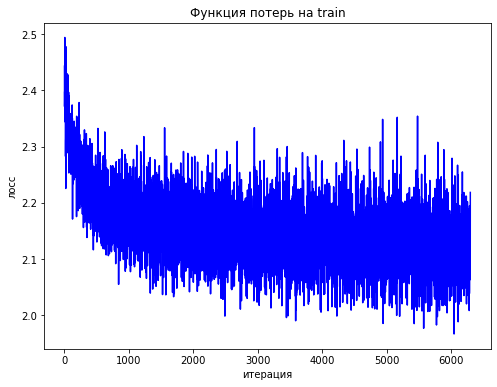

Current loss: 2.218441


In [114]:
in_num = X.shape[1]
out_num = 10
batch_size = 128
n_epoch = 100

'''nn.Linear(in_num, 128),
    nn.Dropout(p=0.4),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 64),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 32),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm1d(32),
    nn.Linear(32, out_num),
    nn.LogSoftmax()'''
net_torch = nn.Sequential(
    nn.Linear(in_num, 256),
    nn.Dropout(p=0.4),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, out_num),
    nn.LogSoftmax()
)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net_torch.parameters())

net_torch, loss_history = train_model_torch(
    net_torch, X_train, y_train, 
    criterion,
    optimizer,
    n_epoch,
    batch_size
)

In [115]:
def test_generator(sample):
    '''
    Батч-генератор для тестовых данных (без меток).
    '''
    n_samples = sample.shape[0]
    indices = np.arange(n_samples)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield sample[batch_idx]

In [109]:
def test_torch(model, test_sample):
    '''
    Тестирует модель из PyTorch на тестовой выборке.
    '''
    model.eval()
    preds = []
    with torch.no_grad():
        for test_batch in test_generator(test_sample):
            preds_batch = model(torch.FloatTensor(test_batch))
            preds_batch = preds_batch.argmax(axis=1).reshape(-1,1)
            preds.append(preds_batch.detach().numpy())
    preds = np.vstack(preds)
    return preds

In [116]:
y_pred = test_torch(net_torch, X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}\nMAE: {mae(y_test, y_pred)}')

Accuracy: 0.183
MAE: 2.3975


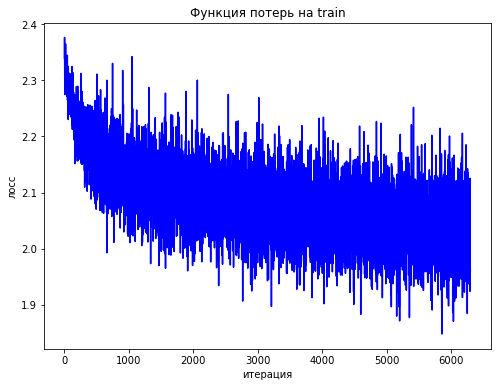

Current loss: 1.960200
Accuracy: 0.182
MAE: 2.193


In [118]:
in_num = X.shape[1]
out_num = 10
batch_size = 128
n_epoch = 100

net_torch = nn.Sequential(
    nn.Linear(in_num, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, out_num),
    nn.LogSoftmax()
)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net_torch.parameters())

net_torch, loss_history = train_model_torch(
    net_torch, X_train, y_train, 
    criterion,
    optimizer,
    n_epoch,
    batch_size
)
y_pred = test_torch(net_torch, X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}\nMAE: {mae(y_test, y_pred)}')

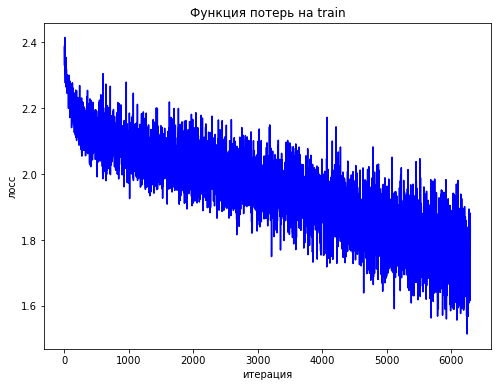

Current loss: 1.846404
Accuracy: 0.1555
MAE: 2.4465


In [134]:
in_num = X.shape[1]
out_num = 10
batch_size = 128
n_epoch = 100

net_torch = nn.Sequential(
    nn.Linear(in_num, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, out_num),
    #nn.ReLU(),
    nn.LogSoftmax()
)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net_torch.parameters())

net_torch, loss_history = train_model_torch(
    net_torch, X_train, y_train, 
    criterion,
    optimizer,
    n_epoch,
    batch_size
)
y_pred = test_torch(net_torch, X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}\nMAE: {mae(y_test, y_pred)}')

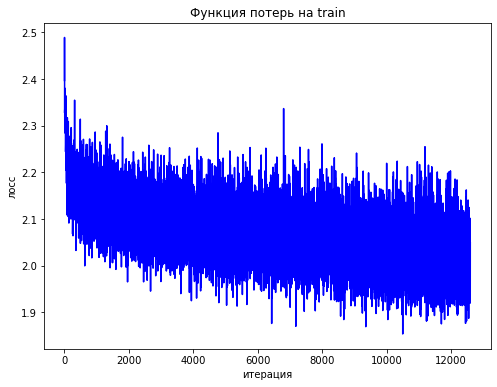

Current loss: 2.049173
Accuracy: 0.178
MAE: 2.176


In [137]:
in_num = X.shape[1]
out_num = 10
batch_size = 128
n_epoch = 200

net_torch = nn.Sequential(
    nn.Linear(in_num, 256),
    nn.BatchNorm1d(256),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(64, out_num),
    #nn.ReLU(),
    nn.LogSoftmax()
)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net_torch.parameters(), lr=1e-2)

net_torch, loss_history = train_model_torch(
    net_torch, X_train, y_train, 
    criterion,
    optimizer,
    n_epoch,
    batch_size
)
y_pred = test_torch(net_torch, X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}\nMAE: {mae(y_test, y_pred)}')

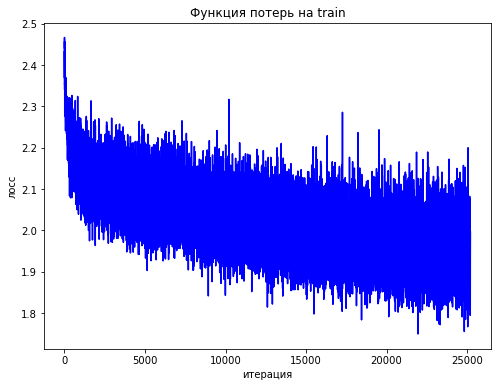

Current loss: 1.997374
Accuracy: 0.177
MAE: 2.251


In [138]:
in_num = X.shape[1]
out_num = 10
batch_size = 128
n_epoch = 400

net_torch = nn.Sequential(
    nn.Linear(in_num, 256),
    nn.BatchNorm1d(256),
    nn.Dropout(p=0.4),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(64, out_num),
    #nn.ReLU(),
    nn.LogSoftmax()
)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net_torch.parameters())

net_torch, loss_history = train_model_torch(
    net_torch, X_train, y_train, 
    criterion,
    optimizer,
    n_epoch,
    batch_size
)
y_pred = test_torch(net_torch, X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}\nMAE: {mae(y_test, y_pred)}')